## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path ='drive/MyDrive/Code/Scripts/'
path_data ='drive/MyDrive/Data/'

import sys, os, random
sys.path.append(path)

import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp

import tensorflow as tf
from Model import CO2_regressor
from Visualization import train_test_plot_CO2
from Utils import pre_process_CO2

seed=42

Mounted at /content/drive


## Setting Seeds

In [ ]:
def seed_everything(seed):
  os.environ['PYTHONHASHSEED']=str(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

def set_global_determinism(seed):
  seed_everything(seed=seed)

  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
  tf.config.threading.set_inter_op_parallelism_threads(1)
  tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed)

## Data

### Loading

In [ ]:
with h5py.File(path_data+'CO2/train.h5', 'r') as f:
  data_train = np.concatenate((f['data'][:], f['label'][:]), axis=1)
with h5py.File(path_data+'CO2/test.h5', 'r') as f:
  data_test = np.concatenate((f['data'][:], f['label'][:]), axis=1)

X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

# Taking test data as complete train-data and extrapolated points
X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

### Visualising

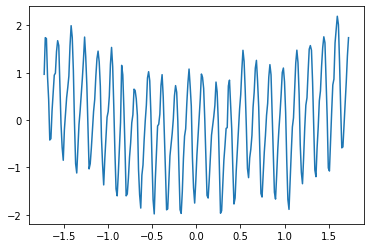

In [ ]:
plt.plot(X_train, y_train)

### Pre-processing

In [ ]:
X_train, y_train=pre_process_CO2(X_train,y_train, normalize=False)

## Training

### Normal Dropout

In [ ]:
%%time
my_model_normal=CO2_regressor(hidden=[1024, 1024, 1024, 1024, 1024], drop_rate=0.1, activation='relu', shape=X_train.shape, gaussian=False)
history= my_model_normal.train(X_train, y_train, batch_size=128, lr=0.0001, max_epoch=100000, verbose=1)

Streaming output truncated to the last 5000 lines.
Epoch 97502/100000
3/3 [==============================] - 0s 15ms/step - loss: 0.0559 - mse: 0.0518
Epoch 97503/100000
3/3 [==============================] - 0s 14ms/step - loss: 0.0672 - mse: 0.0631
Epoch 97504/100000
3/3 [==============================] - 0s 17ms/step - loss: 0.0683 - mse: 0.0641
Epoch 97505/100000
3/3 [==============================] - 0s 17ms/step - loss: 0.0703 - mse: 0.0661
Epoch 97506/100000
3/3 [==============================] - 0s 14ms/step - loss: 0.0615 - mse: 0.0573
Epoch 97507/100000
3/3 [==============================] - 0s 16ms/step - loss: 0.0516 - mse: 0.0475
Epoch 97508/100000
3/3 [==============================] - 0s 15ms/step - loss: 0.0671 - mse: 0.0629
Epoch 97509/100000
3/3 [==============================] - 0s 14ms/step - loss: 0.0736 - mse: 0.0694
Epoch 97510/100000
3/3 [==============================] - 0s 14ms/step - loss: 0.0690 - mse: 0.0648
Epoch 97511/100000
3/3 [=========================

In [ ]:
# Saving model and training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(path_data+"History/history_CO2_reg_100000ep_normal_drop")
my_model_normal.save(path_data+'Saved_model/model_CO2_reg_100000ep_normal_drop')

INFO:tensorflow:Assets written to: drive/MyDrive/Data/Saved_model/model_CO2_reg_100000ep_normal_drop/assets


### Gaussian Dropout

In [ ]:
%%time
my_model_gaussian=CO2_regressor(hidden=[1024, 1024, 1024, 1024, 1024], drop_rate=0.1, activation='relu', shape=X_train.shape, gaussian=True)
history= my_model_gaussian.train(X_train, y_train, batch_size=128, lr=0.0001, max_epoch=100000, verbose=1)

Streaming output truncated to the last 5000 lines.
Epoch 97502/100000
3/3 [==============================] - 0s 13ms/step - loss: 0.0016 - mse: 6.8155e-04
Epoch 97503/100000
3/3 [==============================] - 0s 12ms/step - loss: 0.0023 - mse: 0.0013
Epoch 97504/100000
3/3 [==============================] - 0s 13ms/step - loss: 0.0019 - mse: 9.3537e-04
Epoch 97505/100000
3/3 [==============================] - 0s 12ms/step - loss: 0.0015 - mse: 4.8737e-04
Epoch 97506/100000
3/3 [==============================] - 0s 12ms/step - loss: 0.0016 - mse: 6.3426e-04
Epoch 97507/100000
3/3 [==============================] - 0s 11ms/step - loss: 0.0019 - mse: 9.3374e-04
Epoch 97508/100000
3/3 [==============================] - 0s 11ms/step - loss: 0.0018 - mse: 7.9512e-04
Epoch 97509/100000
3/3 [==============================] - 0s 11ms/step - loss: 0.0017 - mse: 7.8208e-04
Epoch 97510/100000
3/3 [==============================] - 0s 11ms/step - loss: 0.0015 - mse: 5.4690e-04
Epoch 97511/10000

In [ ]:
# Saving model and training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(path_data+"History/history_CO2_reg_100000ep_gaussian_drop")
my_model_gaussian.save(path_data+'Saved_model/model_CO2_reg_100000ep_gaussian_drop')

INFO:tensorflow:Assets written to: drive/MyDrive/Data/Saved_model/model_CO2_reg_100000ep_gaussian_drop/assets


## Inference

In [ ]:
X_test= pre_process_CO2(X_test, normalize=False)

### Normal Dropout

In [ ]:
%%time
yt = my_model_normal.get_predictions(X_test, T=5000)
y_mc = yt.mean(axis=0)
y_mc_std = yt.std(axis=0)

CPU times: user 9min 39s, sys: 20 s, total: 9min 59s
Wall time: 12min 20s


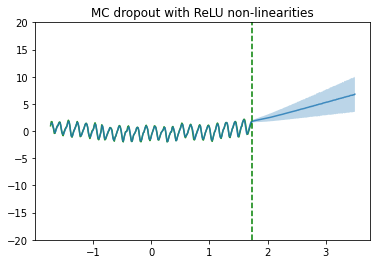

In [ ]:
with open(path_data+'Pickle_Files/yt_CO2_reg_100000ep_normal_drop.pkl', 'wb') as f:
  pickle.dump(yt, f)
train_test_plot_CO2(X_train=X_train, y_train = y_train,X_test = X_test,y_mc=y_mc,y_mc_std=y_mc_std)

### Gaussian Dropout

In [ ]:
%%time
yt = my_model.get_predictions(X_test, T=5000)
y_mc = yt.mean(axis=0)
y_mc_std = yt.std(axis=0)

CPU times: user 9min 3s, sys: 20.7 s, total: 9min 24s
Wall time: 12min 3s


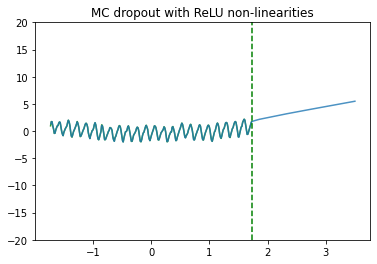

In [ ]:
with open(path_data+'Pickle_Files/yt_CO2_reg_100000ep_gaussian_drop.pkl', 'wb') as f:
  pickle.dump(yt, f)
train_test_plot_CO2(X_train=X_train, y_train = y_train,X_test = X_test,y_mc=y_mc,y_mc_std=y_mc_std)

## Results

### Training History

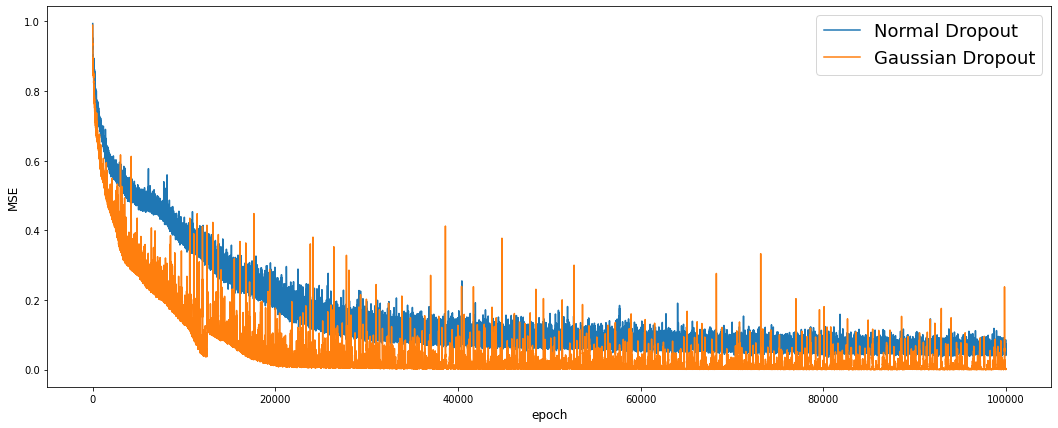

In [ ]:
# Reading training histories
normal_df=pd.read_csv(path_data+"History/history_CO2_reg_100000ep_normal_drop", index_col=0)
gaussian_df= pd.read_csv(path_data+"History/history_CO2_reg_100000ep_gaussian_drop", index_col=0)

# Plotting
plt.figure(figsize=(18,7))
plt.plot(normal_df['mse'])
plt.plot(gaussian_df['mse'])
plt.ylabel('MSE',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['Normal Dropout', 'Gaussian Dropout'], loc='upper right', fontsize=18)
plt.savefig('CO2_history.png')

### RMSE and Log-likelihood

Taking $\tau=0.427114830213$ 

#### Gaussian Dropout

In [ ]:
model_1= tf.keras.models.load_model(path_data+'Saved_model/model_CO2_reg_100000ep_gaussian_drop')
X_test = data_test[:, 0].reshape(-1, 1)
y_test = data_test[:, 1].reshape(-1, 1)
X_test, y_test= pre_process_CO2(X_train,y_train, normalize=False)

yt = np.array([model_1.predict(X_test) for _ in range(5000)]).squeeze()
y_mc = yt.mean(axis=0)
rmse = np.mean((y_test.squeeze() - y_mc.squeeze())**2.)**0.5
ll = (logsumexp(-0.5 * 0.427114830213 * (y_test[None] - y_mc)**2., 0) - np.log(5000) - 0.5*np.log(2*np.pi) + 0.5*np.log(0.427114830213))
test_ll = np.mean(ll)
test_ll, rmse

(-10.288936436781311, 0.032880815721017594)

#### Normal Dropout

In [ ]:
model_2= tf.keras.models.load_model(path_data+'Saved_model/model_CO2_reg_100000ep_normal_drop')
X_test = data_test[:, 0].reshape(-1, 1)
y_test = data_test[:, 1].reshape(-1, 1)
X_test, y_test= pre_process_CO2(X_train,y_train, normalize=False)

yt = np.array([model_2.predict(X_test) for _ in range(5000)]).squeeze()
y_mc = yt.mean(axis=0)
rmse = np.mean((y_test.squeeze() - y_mc.squeeze())**2.)**0.5
ll = (logsumexp(-0.5 * 0.427114830213 * (y_test[None] - y_mc)**2., 0) - np.log(5000) - 0.5*np.log(2*np.pi) + 0.5*np.log(0.427114830213))
test_ll = np.mean(ll)
test_ll, rmse

(-10.26313269877739, 0.16164469845879456)